# Quantitative evaluation

## Setup

### Modules

In [1]:
from pathlib import Path

import autorank
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import Orange
import pickle
import scipy.stats as spst
import scikit_posthocs
import seaborn as sns

import tractseg.config as config
import tractseg.data.dataset_specific_utils

plt.rcParams.update(
    {
        "legend.fontsize": 9,
        "axes.labelsize": 9,
        "axes.titlesize": 9,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
    }
)

### Data

In [2]:
DATASET = "HCP105"
CLASSSET = "bundles_all72"
CVFOLD = 0

EXPERIMENTS = ["peaks", "fodfs", "rank_3_approx"]
FILENAME_RESULTS = "experiment_test.pkl"

path_dir_experiments = Path(config.PATH_DIR_EXP)
paths_results = [path_dir_experiments / experiment / FILENAME_RESULTS for experiment in EXPERIMENTS]

### Utilities

In [3]:
def loadall(path):
    with open(path, "rb") as f:
        while True:
            try:
                yield pickle.load(f)
            except EOFError:
                break


def load_results(path):
    result = list(loadall(path))[0]
    return result

## Plotting results

In [4]:
subjects_test = np.asarray(tractseg.data.dataset_specific_utils.get_cvfold(DATASET, CVFOLD)[2])
tracts = np.asarray(tractseg.data.dataset_specific_utils.get_classes(CLASSSET))

display(subjects_test[:5], tracts[:5])

array(['904044', '907656', '910241', '912447', '917255'], dtype='<U6')

array(['AF_left', 'AF_right', 'ATR_left', 'ATR_right', 'CA'], dtype='<U14')

In [5]:
results = dict(zip(EXPERIMENTS, [load_results(path_result) for path_result in paths_results]))

display(results)

{'peaks': {'metrics': {'loss_test': [0.0],
   'f1_macro_test': [0.8374918984973109]},
  'metrics_bundles': {'AF_left': [0.8703017677693398],
   'AF_right': [0.8610039905446006],
   'ATR_left': [0.8805388370510302],
   'ATR_right': [0.8755520519552472],
   'CA': [0.6607658231591683],
   'CC_1': [0.8278656599229768],
   'CC_2': [0.9185710433869816],
   'CC_3': [0.8251559266692828],
   'CC_4': [0.8754922129839151],
   'CC_5': [0.836432379573176],
   'CC_6': [0.8565621479871256],
   'CC_7': [0.7852310664114759],
   'CG_left': [0.8448743421442764],
   'CG_right': [0.8594297746656397],
   'CST_left': [0.8568537083784195],
   'CST_right': [0.8499797681913531],
   'MLF_left': [0.882479008661035],
   'MLF_right': [0.8722326666014252],
   'FPT_left': [0.8773487474718442],
   'FPT_right': [0.872038192995397],
   'FX_left': [0.6906533881898306],
   'FX_right': [0.6314861120730949],
   'ICP_left': [0.8297198980842085],
   'ICP_right': [0.8243689964109762],
   'IFO_left': [0.8172080790440275],
   'I

### Per subject

In [6]:
dices_subjects = np.asarray([results[experiment]["f1_scores"] for experiment in EXPERIMENTS])

display(dices_subjects)

array([[0.8438301 , 0.84177501, 0.85179342, 0.8080041 , 0.826523  ,
        0.82484951, 0.83995137, 0.84467087, 0.85093374, 0.86132758,
        0.83418549, 0.84102005, 0.81973322, 0.81280036, 0.84180717,
        0.83078424, 0.86054064, 0.84432991, 0.83826987, 0.82160042,
        0.8485998 ],
       [0.84436181, 0.84502613, 0.85439893, 0.81656765, 0.82685134,
        0.82956553, 0.83981766, 0.8475285 , 0.85304827, 0.86577488,
        0.8368057 , 0.84389208, 0.82074531, 0.81546367, 0.84568185,
        0.83150795, 0.8637387 , 0.8486642 , 0.84045085, 0.82488995,
        0.85052776],
       [0.84160407, 0.84510996, 0.85040296, 0.80668697, 0.82304057,
        0.82469242, 0.83788216, 0.84157338, 0.8495633 , 0.86189783,
        0.83473148, 0.83979646, 0.81602618, 0.81033315, 0.84072615,
        0.8276121 , 0.85918254, 0.8442564 , 0.83844899, 0.81565337,
        0.84768163]])

In [7]:
dices_means = np.mean(dices_subjects, axis=1)

display(dices_means)

array([0.8374919 , 0.8402528 , 0.83604296])

In [8]:
differences_means = np.mean(np.abs(dices_subjects - dices_means[:, None]), axis=0)
subject_closest_to_means = subjects_test[np.argmin(differences_means)]

display(subject_closest_to_means)

'987983'

In [9]:
def plot_results_subjects(dices_subjects):
    dina4 = np.array([0.21, 0.297]) * 39.37
    fig = plt.figure(figsize=dina4)
    ax = fig.add_subplot(4, 2, 1)

    sns.boxplot(
        data=dices_subjects.T,
        orient="y",
        showmeans=True,
        meanprops={"color": "tab:red"},
        meanline=True,
        ax=ax,
    )

    ax.set_xlabel("Dice")
    # ax.set_ylabel("Tract")
    ax.set_yticks(np.arange(dices_subjects.shape[0]))
    ax.set_yticklabels(["fODF peaks", "fODF tensor", r"rank-$3$" + "\napproximation"])
    ax.tick_params(top=False, bottom=True, left=False, right=False, labelleft=True, labelbottom=True)
    ax.grid(alpha=0.6, axis="x")

    def set_xmargin(ax, left=0.0, right=0.0):
        ax.set_xmargin(0)
        ax.autoscale_view()
        lim = ax.get_xlim()
        delta = np.diff(lim)
        left = lim[0] - delta * left
        right = lim[1] + delta * right
        ax.set_xlim(left, right)

    set_xmargin(ax, left=0.26, right=0.05)

    dices_means = np.mean(dices_subjects, axis=1).round(4)
    offset = np.mean(dices_subjects) * 0.05

    for ytick in ax.get_yticks():
        ax.text(
            np.min(dices_subjects) - 0.01,
            ytick + 0.05,
            dices_means[ytick],
            horizontalalignment="center",
            size="x-small",
            color="tab:red",
            weight="semibold",
        )

    plt.tight_layout()
    plt.show()

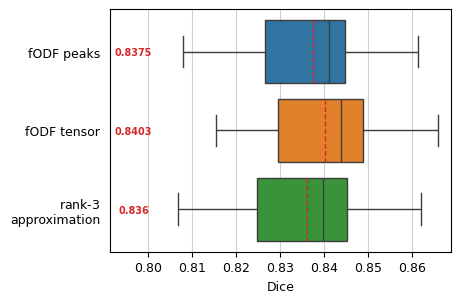

In [10]:
plot_results_subjects(dices_subjects)

### Per tract

In [11]:
def sort_results(results, tracts):
    # Kind of terrible format the data is stored in the pickle.
    dices_bundles = [np.asarray(list(results[experiment]["metrics_bundles"].values())).T[0] for experiment in EXPERIMENTS]
    ids_sorted = np.argsort(dices_bundles[0])

    dices_bundles_sorted = [dice_bundles[ids_sorted] for dice_bundles in dices_bundles]
    tracts_sorted = tracts[ids_sorted]
    return dices_bundles_sorted, tracts_sorted

In [12]:
def plot_results_tracts(dices_bundles_sorted, tracts_sorted):
    dina4 = np.array([0.21, 0.297]) * 39.37
    fig = plt.figure(figsize=dina4)
    ax = fig.add_subplot(1, 2, 1)

    # Keep plotting explicit.
    ax.scatter(dices_bundles_sorted[0], tracts_sorted, marker="o", label=r"fODF peaks")
    ax.scatter(dices_bundles_sorted[1], tracts_sorted, marker="*", label=r"fODF tensor")
    ax.scatter(dices_bundles_sorted[2], tracts_sorted, marker="+", label=r"Rank-$3$ approximation")

    ax.set_xlabel("Dice")
    # ax.set_ylabel("Tract")
    ax.set_ymargin(0.015)
    ax.tick_params(top=False, bottom=True, left=False, right=False, labelleft=True, labelbottom=True)
    ax.grid(alpha=0.6)
    ax.legend()

    plt.tight_layout()
    plt.show()

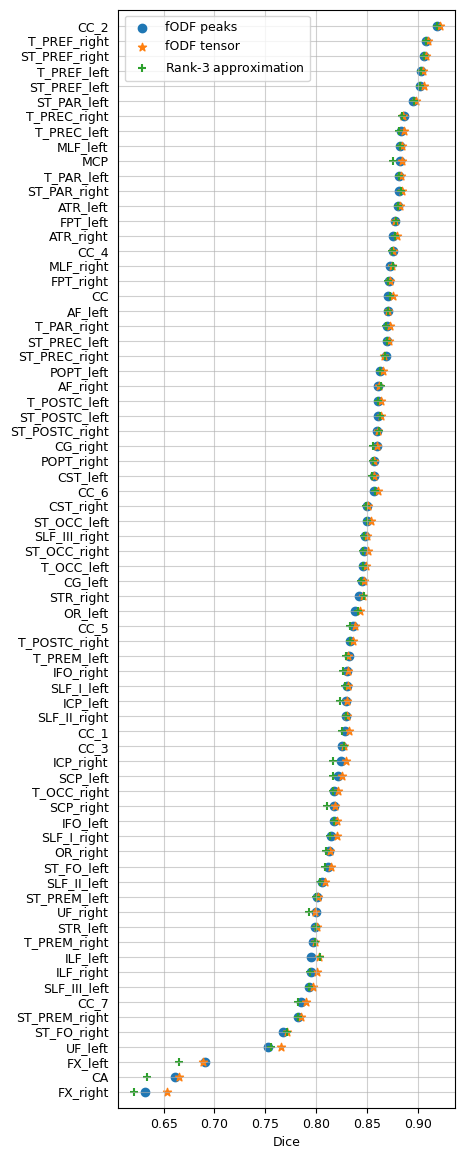

In [13]:
dices_bundles_sorted, tracts_sorted = sort_results(results, tracts)

plot_results_tracts(dices_bundles_sorted, tracts_sorted)

## Statistical testing

In [14]:
df_dices_subjects = pd.DataFrame(dices_subjects)

display(df_dices_subjects)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.843830,0.841775,0.851793,0.808004,0.826523,0.824850,0.839951,0.844671,0.850934,0.861328,...,0.841020,0.819733,0.812800,0.841807,0.830784,0.860541,0.844330,0.838270,0.821600,0.848600
1,0.844362,0.845026,0.854399,0.816568,0.826851,0.829566,0.839818,0.847529,0.853048,0.865775,...,0.843892,0.820745,0.815464,0.845682,0.831508,0.863739,0.848664,0.840451,0.824890,0.850528
2,0.841604,0.845110,0.850403,0.806687,0.823041,0.824692,0.837882,0.841573,0.849563,0.861898,...,0.839796,0.816026,0.810333,0.840726,0.827612,0.859183,0.844256,0.838449,0.815653,0.847682


In [15]:
result_friedman = spst.friedmanchisquare(*dices_subjects)

display(result_friedman)

FriedmanchisquareResult(statistic=29.809523809523796, pvalue=3.3646829750653805e-07)

In [16]:
result_nymenyi = scikit_posthocs.posthoc_nemenyi_friedman(dices_subjects.T)

display(result_nymenyi)

,0,1,2
0,1.000000,0.001988,0.110842
1,0.001988,1.000000,0.001000
2,0.110842,0.001000,1.000000


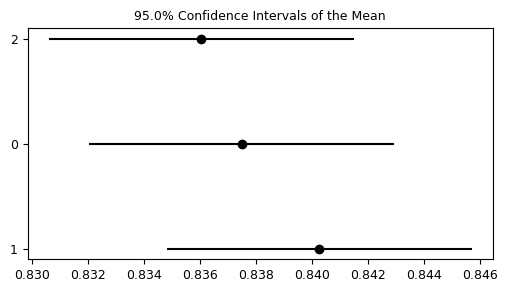

In [17]:
result = autorank.autorank(df_dices_subjects.T, alpha=0.05)
autorank.plot_stats(result)
plt.show()

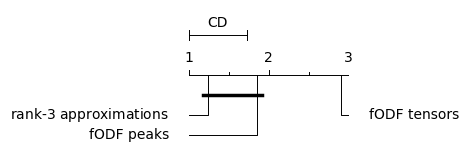

In [18]:
names = ["fODF peaks", "fODF tensors", r"rank-$3$ approximations"]
avranks = df_dices_subjects.rank(axis=0).mean(axis=1).values
cd = Orange.evaluation.compute_CD(avranks, 21)
Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=1.6, textspace=0)
plt.show()